# Fashion-MNIST with multilayer perceptron

In this notebook we will build a multi-layer perceptron from scratch and train it on the Fashion-MNIST dataset. The purpose of building this model from scratch is to develop a deeper understanding of how a fully connected feed forward neural network works.

Before we build the neural network lets get a closer look at the dataset we will be working with as well import the packages which will be used throughout the notebook.

## Packages

Run the cell below to import the packages.

In [1]:
import numpy as np  #The numpy package provides a collection of basic routines for manipulating large arrays and matrices
import idx2numpy    #This package will convert our data from idx3-ubyte format to a numpy array
import PIL          #This package provides image processing capabilities, it will be used to visualize our data
import time         #The time package provides functions to find out the running time of our algorithms

from matplotlib import pyplot as plt #This function will be used inconjunction with PIL package to visualize our data
from ADAM_optimizer import *         #Import ADAM optimization algorithm, much more efficient than gradient descent
from nn_mlp_functions import *       #The functions used for this network. The functions descriptions are provided in the python file.

The lower level functions (eg. Relu, it's gradient, etc.) are implemented in a separted file <b>nn_mlp_functions</b>.


## The Data

For this exercise we will be using the Fashion-MNIST dataset. The data was collected by Zolando Research as a replacement for MNIST.[[1]](#a)
<br>
This dataset has pictures of every Zolando's fashion product. There are 60000 images in the "train-images-idx3-ubyte" with the corresponding labels in "train-labels-idx1-ubyte". Each image is a 28x28 8-bit greyscale picture.

Lets only import the training data right now, we will import the test data at the time when we test our neural network.

In [2]:
X_train_orig = idx2numpy.convert_from_file('data/train-images-idx3-ubyte')
Y_train_orig = idx2numpy.convert_from_file('data/train-labels-idx1-ubyte')

<br>
<u>Table 1</u> below gives a summary of the data.

![title](Pictures/Fashion-MNIST_visual_table.JPG)

<caption><center> <u>Table_1</u>: Name of classes and example images in our data set. <br> </center></caption>

<br>
With the code below we can inspect the individual images in the dataset.

Image belongs to class: 0


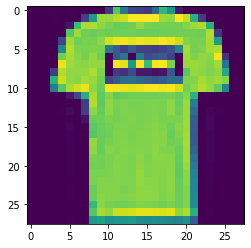

In [3]:
index = 1 #Change this to get a different image, python indexes from 0 therefore the index for our dataset will be from 0-59999
image = X_train_orig[index] #The image we want
plt.imshow(image) #Display the image

print("Image belongs to class: "+str(Y_train_orig[index]))

<br>
Lets also have a look at the shape of our dataset.

In [4]:
print(Y_train_orig.shape)

(60000,)


<b>Y_train_orig</b> is a (60000,) array. For our neural network we will convert it to a (10,60000) array.

The code below will convert <b>Y_train_orig</b> to a (10,60000) matrix. We will call this new matrix <b>Y_train</b>, which we will use in our neural network.

In [5]:
classes = 10               #Number of classes for our dataset
m = Y_train_orig.shape[0]  #Number of training examples in our dataset i.e 60000

Y_train_orig = Y_train_orig.reshape(1, m)               #Reshape our matrix from (60000,) to (60000,1)
#print(Y_train_orig.shape)
Y_train = np.eye(classes)[Y_train_orig.astype('int32')] #
Y_train = Y_train.T.reshape(classes, m)                 #Reshape the Y_train matrix to (10,60000)

print(Y_train.shape) #print the shape of Y_train

(10, 60000)


The output matches our expectation. Lets move on.


## Reshaping and Standardizing the input

We will reshape our <b>X_train_orig</b> matrix to a (784,60000) matrix. All pixels values will we unrolled into a single column, therefore 28x28=784. This will be done for all 60000 training examples.
<br>
<br>
We also will standardize our input feature matrix <b>X_train_orig</b>. This will help our algorithm converge faster. Generally we standardize the data by subtracting the mean of <b>X_train_orig</b> from each value in it and dividing by the standard deviation of <b>X_train_orig</b>, but for image data dividing each value of <b>X_train_orig</b> with 255(max value of a pixel) works as well.

In [6]:
X_train_orig = X_train_orig.reshape(X_train_orig.shape[0], -1).T #Reshape the X_train_orig matrix to (784,60000)
X_train = X_train_orig/255                                       #Normalize the X_train_orig matrix and save it to X_train

Lets check out if the code outputs the correct shape.

In [7]:
print ("X_train: " + str(X_train.shape))
print ("Y_train: " + str(Y_train.shape))

X_train: (784, 60000)
Y_train: (10, 60000)


Our data is processed and we are ready to feed it to our network.

## The neural network architecture

![title](Pictures/nn_diagram.jpg)

The image above summarizes general architure of a neural network with softmax layer. The code is written in a way that the user has the control over how many layers they want and how many hidden units each layer should have.<br>
For this exercise we will be implementing a 3-layer network. Our network will be (50,50,10) where the last layer is the softmax layer. We will now define our neural network model.

Our network will be doing the following during training:-
1. Feed inputs
2. Forward propagate
3. Compute the current cost for the current predictions
4. Back propagate the gradients
5. Update parameters
6. Do steps 1-5 for the prescribed number of iterations
<br>

The activation function for our hidden units will be ReLU activation function. The tanh and sigmoid functions have the problem of vanishing gradient if the input to the activation function becomes large, slowing down learning. whereas the ReLU function has constant gradient this helps with learning. [[2]](#2)<br>
We will be using HE initialization for our parameters(weights and biases) as it performs well with ReLU.[[3]](#3) <br>
For Updating parameters our algorithm is going to be ADAM as it performs very well. [[4]](#4)

After we have trained our network we will make predictions using the test dataset.

In [8]:
def nn_mlp(X, Y, nn_dimen, learning_rate, num_iters):
    """
    Implementation of a muli layer perceptron
    
    Inputs: X -> Matrix of training examples
            Y -> Matrix of corresponding ground truth values
            nn_dimen -> The dimensions of neural network, number of layers and number of hidden units in each layer
            learning_rate -> The learning rate for optimization algorithm
            num_iters -> Number of iterations for which we want to train the model
            
    Outputs: paramaters -> Python dictionary containing the trained paramaters for our model
    """
    
    #np.random.seed(1)
    parameters = initialize_parameters_nn_HE(nn_dimen)#initialize the parameters
    
    v,s = initialize_parameters_adam(parameters)
    
    derivatives = {} #Python dictionary to store derivatives
    
    costs = [] #list of costs, used for plotting
    L = len(parameters) // 2 
    m = Y.shape[1]
    
    #start of for loop to run the model for num_iters
    for i in range(num_iters):
        
        #Forward propagation step
        Act_L , caches = nn_mlp_forwardpropagation(X, parameters, L)
        
        #Compute the cost
        cost = cross_entropy_loss(Act_L, Y)
        
        if i % 10 == 0 :
            print("Cost after iteration %i: %f" %(i, cost)) #print cost after every 10 iterations
            costs.append(cost)
        
        #Backward propagation
        derivatives = nn_mlp_backwardpropagation(derivatives, Act_L, Y, caches, L)
        
        #update parameters
        t = 2
        parameters, v, s = update_parameters_ADAM(parameters, derivatives, v, s, t, learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
        #parameters = update_parameters(parameters, derivatives, learning_rate)
    #End of for loop to run the model for num_iters
    
    #Plot the cost versus iterations
    plt.plot(np.squeeze(costs))
    plt.title("Cost for learning rate:" +str(learning_rate))
    plt.xlabel("Number of iterations /100")
    plt.ylabel("Cost")
    plt.show
    
    return parameters

<br>Time to train the model the cell below will start training the network!

Cost after iteration 0: 2.441677
Cost after iteration 10: 0.893358
Cost after iteration 20: 0.655856
Cost after iteration 30: 0.550169
Cost after iteration 40: 0.496176
Cost after iteration 50: 0.460780
Cost after iteration 60: 0.435499
Cost after iteration 70: 0.415107
Cost after iteration 80: 0.399076
Cost after iteration 90: 0.385373
Cost after iteration 100: 0.374048
Cost after iteration 110: 0.364056
Cost after iteration 120: 0.355731
Cost after iteration 130: 0.347821
Cost after iteration 140: 0.340689
Cost after iteration 150: 0.333947
Cost after iteration 160: 0.328188
Cost after iteration 170: 0.322623
Cost after iteration 180: 0.317370
Cost after iteration 190: 0.313813
Cost after iteration 200: 0.310246
Cost after iteration 210: 0.305135
Cost after iteration 220: 0.300957
Cost after iteration 230: 0.298699
Cost after iteration 240: 0.295169
Cost after iteration 250: 0.291103
Cost after iteration 260: 0.287497
Cost after iteration 270: 0.286487
Cost after iteration 280: 0.283

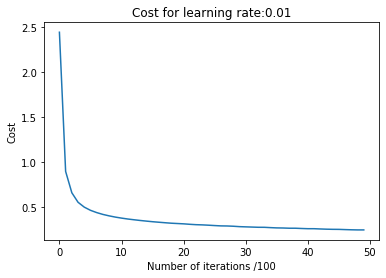

In [9]:
nn_dimen = [X_train.shape[0], 50, 50, classes]

t =time.time() #start timer
parameters = nn_mlp(X_train, Y_train, nn_dimen, 0.01, 500)
elapsed = time.time() -t #stop timer
print(elapsed) #time taken for algorithm

We will first test the model on the training dataset.
<br>For convenience we will use sklearn's classification report.

In [10]:
from sklearn.metrics import classification_report

In [11]:
Act_L, _ = nn_mlp_forwardpropagation(X_train, parameters, len(parameters)//2)

predictions = np.argmax(Act_L, axis=0)
labels = np.argmax(Y_train, axis=0)

In [12]:
print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      5921
           1       0.99      0.99      0.99      5971
           2       0.82      0.86      0.84      5750
           3       0.93      0.91      0.92      6167
           4       0.86      0.82      0.84      6271
           5       0.99      0.99      0.99      5986
           6       0.75      0.77      0.76      5894
           7       0.97      0.97      0.97      6019
           8       0.99      0.98      0.98      6023
           9       0.98      0.98      0.98      5998

    accuracy                           0.91     60000
   macro avg       0.91      0.91      0.91     60000
weighted avg       0.91      0.91      0.91     60000



<br>Lets test the model on the test set. For that we first have to import the test dataset. The cell below does that.

In [13]:
X_test = idx2numpy.convert_from_file('data/t10k-images-idx3-ubyte')
X_test= X_test.reshape(X_test.shape[0], -1).T

Y_test_orig = idx2numpy.convert_from_file('data/t10k-labels-idx1-ubyte')
Y_test_orig = Y_test_orig.reshape((1, 10000))
Y_test = np.eye(classes)[Y_test_orig.astype('int32')]
Y_test = Y_test.T.reshape(classes, 10000)

In [14]:
Act_L, _ = nn_mlp_forwardpropagation(X_test/255, parameters, len(parameters)//2)

predictions = np.argmax(Act_L, axis=0)
labels = np.argmax(Y_test, axis=0)


print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       967
           1       0.97      0.97      0.97       996
           2       0.76      0.79      0.77       963
           3       0.89      0.87      0.88      1023
           4       0.82      0.78      0.80      1043
           5       0.95      0.96      0.96       985
           6       0.68      0.68      0.68      1011
           7       0.95      0.93      0.94      1022
           8       0.95      0.97      0.96       988
           9       0.95      0.95      0.95      1002

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



The overall accuracy of our network is 87%, however the network tends to perform poorly on some classes. Class six stands out in this regards with the lowest f1-score. We can try training the network longer but that might lead to more overfitting for the other classes.<br>
Furthermore our network has an accuracy of 91% on train set whereas it has an accuracy of 87% on the test set. This shows that the network is slightly overfitting the training data. 

<br> The code below will display an image from the test set, it's true class as well as the class that our algorithm has predicted.

The actual class of this image is: 2
The NN predicts that this image belongs to class:2


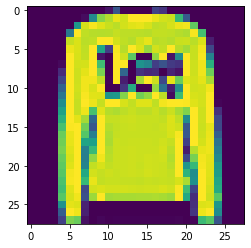

In [15]:
X_test = X_test.reshape((28,28,10000))

index = 1
image = X_test[:,:,index]
plt.imshow(image)
print("The actual class of this image is:",+(labels[index]))
print("The NN predicts that this image belongs to class:"+str(predictions[index]))


## Conclusion

The network we trained provides decent results however there is room for improvement. As mentioned previously it has an accuracy of 91% on the training set and 87% on the test set. This shows that it is overfitting the training data and regularization techinques like dropout, L2 regularition, etc. will help. Getting more data will also help but that might not be possible for this dataset therefore data augmentation will also be helpful.<br>
We trained the neural network using the entire training set, our network updates paramaters after going through the entire training set. Splitting the training data into mini-batches and then training the network is more efficient. The optimization algorithm will update parameters after going through the mini-batch instead of going through the entire training set. e.g 128 examples in minibatch instead of 60000 examples.

### Moving forward

If the image is of higher resolution than a fully connected MLP might not be the best option as the number of parameters can become very large and training them might be computationally infeasible.<br>
Furthermore a MLP does not have built-in invariance with respect translations and local distortions of the input.[[5]](#5) <br>
In the next notebook we will look at Convolutional neural networks which are widely used for computer vision tasks and address the problems we mentioned here.

## References

<a id="a"></a>1. H. Xiao, K. Rasul, R. Vollgraf. Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. *arXiv preprint arXiv:1708.07747 [cs.LG]*, 2017.
<br>
<a id="2"></a>2. Krizhevsky, Alex, Sutskever, Ilya, and Hinton, Geoffrey E.  Imagenet classification with deep convolutionalneural networks. InAdvances in neural information processing systems, pp. 1097–1105, 2012.
<br>
<a id="3"></a>3. K. He, X. Zhang, S. Ren, J. Sun. Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification. *arXiv preprint arXiv:1502.01852 [cs.CV]*, 2015.
<br>
<a id="4"></a>4. D. P. Kingma, J. Ba. Adam: A Method for Stochastic Optimization. *arXiv preprint arXiv:1412.6980v9 [cs.LG]*, 2017.
<br>
<a id="5"></a> 5. Y. Lecun, L. Bottou, Y. Bengio, P. Haffner, "Gradient-based learning applied to document recognition", Proc. IEEE, vol. 86, no. 11, pp. 2278-2324, 1998.
<br>
